# Open Data Science Conference

## Introdução
Esse exemplo usa a base de dados de dígitos da cikit-learn's [digit dataset](http://scikit-learn.org/stable/datasets/index.html#optical-recognition-of-handwritten-digits-dataset) para mostrar um problema de classificação simples usando AutoML.

Neste notebook você verá:
1. Criação de um `Experiment` em um novo `Workspace`.
2. Atachar (ou criar) uma computacao AmlCompute em um workspace.
3. Configurar o AutoML usando `AutoMLConfig`.
4. Treinar o modelo usando AmlCompute (computacão / cluster remoto)
5. Ver os resultados.
6. Testar o melhor modelo encontrado.

In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install inference_schema

  Created wheel for wrapt: filename=wrapt-1.11.1-cp36-cp36m-linux_x86_64.whl size=68492 sha256=4c29ca25b845b16a29b402ad0732e1d628c0e45dc873e7df5f92ac1e4b03314b
  Stored in directory: /home/azureuser/.cache/pip/wheels/89/67/41/63cbf0f6ac0a6156588b9587be4db5565f8c6d8ccef98202fc
Successfully built wrapt
  Found existing installation: wrapt 1.11.2
    Uninstalling wrapt-1.11.2:
      Successfully uninstalled wrapt-1.11.2
You should consider upgrading via the 'pip install --upgrade pip' command.


In [19]:
import logging
import os

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.core.dataset import Dataset
from azureml.train.automl import AutoMLConfig
from azureml.train.automl.run import AutoMLRun

In [20]:
ws = Workspace.from_config()

# Choose a name for the run history container in the workspace.
experiment_name = 'AutoML'
project_folder = './project'

experiment = Experiment(ws, experiment_name)

output = {}
output['SDK version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace Name'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

,
SDK version,1.0.65
Subscription ID,9d89029e-3e7f-473c-be93-27aee0774923
Workspace Name,odscml
Resource Group,odsc
Location,brazilsouth
Project Directory,./project
Experiment Name,AutoML


## Create or Attach existing AmlCompute
Você pode criar ou atachar a um AmlCompute existente. Se usar o nome de um que já existe, simplesmente utilizára ele.
**A criação do AmlCompute leva aproximadamente 5 minutos.** 


In [4]:
%%time
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget

# Choose a name for your cluster.
amlcompute_cluster_name = "clusterODSCSP"

found = False
cts = ws.compute_targets

if amlcompute_cluster_name in cts and cts[amlcompute_cluster_name].type == 'AmlCompute':
    found = True
    print('Compute target já existe.')
    compute_target = cts[amlcompute_cluster_name]

if not found:
    print('Criando novo compute target...')
    provisioning_config = AmlCompute.provisioning_configuration(vm_size = "STANDARD_DS3_V2", max_nodes = 6, min_nodes=1)
    #Cria o cluster
    compute_target = ComputeTarget.create(ws, amlcompute_cluster_name, provisioning_config)

print('Validando o status da criação do cluster...')
compute_target.wait_for_completion(show_output = True, min_node_count = None, timeout_in_minutes = 20)

Compute target já existe.
Validando o status da criação do cluster...
Succeeded
AmlCompute wait for completion finished
Minimum number of nodes requested have been provisioned
CPU times: user 11.3 ms, sys: 11.7 ms, total: 23 ms
Wall time: 521 ms


Para execuções remotas, você precisa tornar o dado acessível pela computação remota. Faremos isso fazendo upload dos dados para o DataStore (storage account criada junto ao AML service workspace).

In [21]:
data_train = datasets.load_digits()

if not os.path.isdir('data'):
    os.mkdir('data')
    
if not os.path.exists(project_folder):
    os.makedirs(project_folder)
    
pd.DataFrame(data_train.data[100:,:]).to_csv("data/X_train.csv", index=False)
pd.DataFrame(data_train.target[100:]).to_csv("data/y_train.csv", index=False)

ds = ws.get_default_datastore()
ds.upload(src_dir='./data', target_path='digitsdata', overwrite=True, show_progress=True)

Uploading an estimated of 2 files
Uploading ./data/X_train.csv
Uploading ./data/y_train.csv
Uploaded ./data/y_train.csv, 1 files out of an estimated total of 2
Uploaded ./data/X_train.csv, 2 files out of an estimated total of 2
Uploaded 2 files


$AZUREML_DATAREFERENCE_365b22144a34458d99fe848430378174

In [22]:
from azureml.core.runconfig import RunConfiguration
from azureml.core.conda_dependencies import CondaDependencies
import pkg_resources

In [23]:
# cria um objeto RunConfig 
conda_run_config = RunConfiguration(framework="python")

# aponta a computaSet compute target to AmlCompute
#conda_run_config.target = compute_target
conda_run_config.environment.docker.enabled = True

cd = CondaDependencies.create(conda_packages=['numpy','py-xgboost<=0.80'])
conda_run_config.environment.python.conda_dependencies = cd

Criando o TabularDataset
Define X e y como TabularDataset, o qual s erá passado para o AutoML no AutoMLConfig. from_delimited_files por padrão configura a opção infer_column_types como true, o q ue fará a detecção dos tipos das colunas automaticamente. Se quiser, pode definir manualmente o tipo de cada coluna com set_column_types.

In [24]:
X = Dataset.Tabular.from_delimited_files(path=ds.path('digitsdata/X_train.csv'))
y = Dataset.Tabular.from_delimited_files(path=ds.path('digitsdata/y_train.csv'))

## Treino

|Propriedade|Descrição|
|-|-|
|**primary_metric**|Esta éa métrica que você quer otimizar. Classificação suporta as seguintes métricas primárias: <br><i>accuracy</i><br><i>AUC_weighted</i><br><i>average_precision_score_weighted</i><br><i>norm_macro_recall</i><br><i>precision_score_weighted</i>|
|**iteration_timeout_minutes**|Limite de tempo (em minutos) para cada iteração.|
|**iterations**|Número de iterações. Em cada iteração AutoML treian um pipeline específico com os dados.|
|**n_cross_validations**|Número de quebras par aa validação cruzada.|
|**max_concurrent_iterations**|Máximo número de iterações a serem executadas em paralelo.|

In [26]:
automl_settings = {
    "iteration_timeout_minutes": 10,
    "iterations": 10,
    "n_cross_validations": 5,
    "primary_metric": 'AUC_weighted',
    "preprocess": False,
    "max_concurrent_iterations": 5,
    "verbosity": logging.INFO
}

automl_config = AutoMLConfig(task = 'classification',
                             debug_log = 'automl_errors.log',
                             path = project_folder,
                             run_configuration=conda_run_config,
                             X = X,
                             y = y,
                             **automl_settings
                            )


Chama agora o método `submit` no objeto de experimento e passa a configuração de execução. 
Para execuções remotas (o caso neste notebook) o processo é assíncrono, então você verá as interações conforme elas completam. 
Você pode interagir com os componentes e modelos mesmo que o processo ainda não tenha terminado (para pegar o melhor modelo até aquele momento). 
Uma vez que você estiver satisfeito com o modelo,, você pode cancelar a execução de uma iteração em particular ou do processo todo.

In [27]:
%%time
remote_run = experiment.submit(automl_config, show_output = True)

Running on local machine
Parent Run ID: AutoML_6a5c2496-978a-4c26-9fe7-dfe0d7c8d1c4
Current status: DatasetCrossValidationSplit. Generating CV splits.

****************************************************************************************************
DATA GUARDRAILS SUMMARY:
For more details, use API: run.get_guardrails()

TYPE:         Class Balancing Detection
STATUS:       PASSED
DESCRIPTION:  Classes are balanced in the training data.

****************************************************************************************************
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
***********************************

## Resultados
Se quiser ver o resultado de uma execução específica, basta fornecer o run_id


Type Markdown and LaTeX: 
𝛼
2
α2

In [10]:
remote_run = AutoMLRun(experiment = experiment, run_id = 'AutoML_a9878d19-22c9-44fd-b3cc-05589d855c78')
remote_run

Experiment,Id,Type,Status,Details Page,Docs Page
AutoML,AutoML_a9878d19-22c9-44fd-b3cc-05589d855c78,automl,Completed,Link to Azure Portal,Link to Documentation


In [28]:
from azureml.widgets import RunDetails
RunDetails(remote_run).show() 

A Jupyter Widget

A Jupyter Widget

In [13]:
remote_run.wait_for_completion(show_output = True)


****************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
****************************************************************************************************

 ITERATION   PIPELINE                                       DURATION      METRIC      BEST
         4   StandardScalerWrapper ExtremeRandomTrees       0:00:13       0.9963    0.9963
         3   StandardScalerWrapper SGD                      0:00:11       0.9892    0.9963
         2   MinMaxScaler LightGBM                          0:00:11       0.9979    0.9979
         1   StandardScalerWrapper SGD                      0:00:12       0.9974    0.9979
         0   StandardScalerWrapper SGD                      0:00:18       0.9945    

{'endTimeUtc': '2019-10-14T14:54:27.494534Z',
 'inputDatasets': [],
 'logFiles': {},
 'properties': {'AMLSettingsJsonString': '{"name": "AutoML", "path": "./project", "subscription_id": "9d89029e-3e7f-473c-be93-27aee0774923", "resource_group": "odsc", "workspace_name": "odscml", "region": "brazilsouth", "compute_target": "local", "spark_service": null, "azure_service": null, "iterations": 10, "primary_metric": "AUC_weighted", "task_type": "classification", "data_script": null, "validation_size": 0.0, "n_cross_validations": 5, "y_min": null, "y_max": null, "num_classes": 10, "featurization": "off", "preprocess": false, "lag_length": 0, "is_timeseries": false, "max_cores_per_iteration": 1, "max_concurrent_iterations": 5, "iteration_timeout_minutes": 10, "mem_in_mb": null, "enforce_time_on_windows": false, "experiment_timeout_minutes": null, "experiment_exit_score": null, "whitelist_models": null, "blacklist_algos": ["XGBoostClassifier", "XGBoostClassifier"], "supported_models": ["Logisti

#### Recuperar todos as execuções
Você pode usar os métodos da SDK para recuperar todoas as execuções filhas e ver as métricas logadas.

In [14]:
children = list(remote_run.get_children())
metricslist = {}
for run in children:
    properties = run.get_properties()
    metrics = {k: v for k, v in run.get_metrics().items() if isinstance(v, float)}
    metricslist[int(properties['iteration'])] = metrics

rundata = pd.DataFrame(metricslist).sort_index(1)
rundata

,0,1,2,3,4,5,6,7,8,9
AUC_macro,0.99,1.00,1.00,0.99,1.00,1.00,1.00,0.99,1.00,0.98
AUC_micro,1.00,1.00,1.00,0.99,1.00,1.00,1.00,0.99,1.00,0.98
AUC_weighted,0.99,1.00,1.00,0.99,1.00,1.00,1.00,0.99,1.00,0.98
accuracy,0.95,0.96,0.95,0.91,0.95,0.94,0.96,0.88,0.96,0.84
average_precision_score_macro,0.98,0.99,0.99,0.94,0.98,0.99,0.99,0.93,0.99,0.92
average_precision_score_micro,0.98,0.99,0.99,0.94,0.98,0.99,0.99,0.93,0.99,0.92
average_precision_score_weighted,0.98,0.99,0.99,0.94,0.98,0.99,0.99,0.93,0.99,0.92
balanced_accuracy,0.95,0.97,0.95,0.91,0.95,0.94,0.96,0.88,0.96,0.85
f1_score_macro,0.95,0.96,0.95,0.91,0.94,0.94,0.96,0.87,0.96,0.82
f1_score_micro,0.95,0.96,0.95,0.91,0.95,0.94,0.96,0.88,0.96,0.84


### Cancelando uma Execução

Você pode cancelar uma execução em andamento rodando as funções `cancel` e `cancel_iteration`.

In [ ]:
# Cancela a operação atual e cancela aspróximas iterações.
# remote_run.cancel()

# Cancela a iteração de número 1 e segue para a de número 2.
# remote_run.cancel_iteration(1)

### Recuperar o melhor modelo

Abaixo nós selecionamos o melhor pipeline dentro nossas iterações. O método `get_output` retorna a melhor execução e o modelo já treinado. O modelo inclui o pipeline e todo os pré-processamentos.
Outras chamadas do método `get_output` permite retornar a melhor execução e modelo treinado para *any* métrica logada ou para uma iteração em específico *iteration*.

In [29]:
best_run, fitted_model = remote_run.get_output()
print(best_run)
print(fitted_model)

Run(Experiment: AutoML,
Id: AutoML_6a5c2496-978a-4c26-9fe7-dfe0d7c8d1c4_8,
Type: None,
Status: Completed)
Pipeline(memory=None,
     steps=[('prefittedsoftvotingclassifier', PreFittedSoftVotingClassifier(classification_labels=None,
               estimators=[('5', Pipeline(memory=None,
     steps=[('StandardScalerWrapper', <automl.client.core.common.model_wrappers.StandardScalerWrapper object at 0x7ff8646619b0>), ('LightGBMClassi...,
               flatten_transform=None,
               weights=[0.5, 0.125, 0.125, 0.125, 0.125]))])


#### Melhor modelo baseado em qualquer outra métrica
Mostre a execução e o modelo que possua o menor valor de `log_loss`:

In [16]:
lookup_metric = "log_loss"
best_run, fitted_model = remote_run.get_output(metric = lookup_metric)
print(best_run)
print(fitted_model)

Run(Experiment: AutoML,
Id: AutoML_939640d4-0352-4f93-92ee-5d08364b1164_1,
Type: None,
Status: Completed)
Pipeline(memory=None,
     steps=[('StandardScalerWrapper', <automl.client.core.common.model_wrappers.StandardScalerWrapper object at 0x7fa38013b860>), ('SGDClassifierWrapper', SGDClassifierWrapper(alpha=1.4286571428571428, class_weight=None, eta0=0.01,
           fit_intercept=True, l1_ratio=0.7551020408163265,
           learning_rate='constant', loss='log', max_iter=1000, n_jobs=1,
           penalty='none', power_t=0.4444444444444444, random_state=None,
           tol=0.001))])


#### Modelo de uma iteração específica
Mostra a execução e o modelo da terceira iteração:

In [41]:
iteration = 1
third_run, third_model = remote_run.get_output(iteration=iteration)
print(third_run)
print(third_model)

Run(Experiment: AutoML,
Id: AutoML_97acf834-df57-4ccc-9e88-889ec25b5620_1,
Type: azureml.scriptrun,
Status: Completed)
Pipeline(memory=None,
     steps=[('StandardScalerWrapper', <automl.client.core.common.model_wrappers.StandardScalerWrapper object at 0x7fc9706d0d30>), ('SGDClassifierWrapper', SGDClassifierWrapper(alpha=1.4286571428571428, class_weight=None, eta0=0.01,
           fit_intercept=True, l1_ratio=0.7551020408163265,
           learning_rate='constant', loss='log', max_iter=1000, n_jobs=1,
           penalty='none', power_t=0.4444444444444444, random_state=None,
           tol=0.001))])


## Testes

#### Carregar os dados para teste

In [30]:
digits = datasets.load_digits()
X_test = digits.data[:10, :]
y_test = digits.target[:10]
images = digits.images[:10]

#### Testando nosso melhor modelo 

4


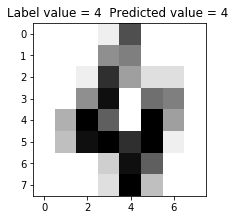

0


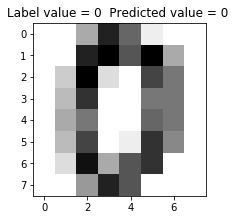

In [31]:
# Selecionar dígitos aleatoriamente e testar.
for index in np.random.choice(len(y_test), 2, replace = False):
    print(index)
    predicted = fitted_model.predict(X_test[index:index + 1])[0]
    label = y_test[index]
    title = "Label value = %d  Predicted value = %d " % (label, predicted)
    fig = plt.figure(1, figsize=(3,3))
    ax1 = fig.add_axes((0,0,.8,.8))
    ax1.set_title(title)
    plt.imshow(images[index], cmap = plt.cm.gray_r, interpolation = 'nearest')
    plt.show()

In [19]:
model = remote_run.register_model(model_name="digitmodel", description="Demo ODSC")

In [20]:
%%writefile myenv.yml
name: project_environment
dependencies:
  # The python interpreter version.
  # Currently Azure ML only supports 3.5.2 and later.
- python=3.6.2

- pip:
  - azureml-train-automl==1.0.65
  - inference-schema
- numpy>=1.16.0,<=1.16.2
- pandas
- scikit-learn
- py-xgboost<=0.80
- fbprophet==0.5
channels:
- conda-forge


Writing myenv.yml


In [21]:
%%writefile score.py
import json
import pickle
import numpy as np
import pandas as pd
import azureml.train.automl
from sklearn.externals import joblib
from azureml.core.model import Model

from inference_schema.schema_decorators import input_schema, output_schema
from inference_schema.parameter_types.numpy_parameter_type import NumpyParameterType
from inference_schema.parameter_types.pandas_parameter_type import PandasParameterType


input_sample = np.array([0.0, 0.0, 0.0, 2.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 16.0, 5.0, 2.0, 0.0, 0.0, 0.0, 0.0, 15.0, 12.0, 1.0, 16.0, 4.0, 0.0, 0.0, 4.0, 16.0, 2.0, 9.0, 16.0, 8.0, 0.0, 0.0, 0.0, 10.0, 14.0, 16.0, 16.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 6.0, 0.0, 0.0])
output_sample = np.array([0])


def init():
    global model
    # This name is model.id of model that we want to deploy deserialize the model file back
    # into a sklearn model
    model_path = Model.get_model_path(model_name = 'digitmodel')
    model = joblib.load(model_path)


    
def run(raw_data):

    try:

        data = json.loads(raw_data)['data']

        data = np.array(data)

        result = model.predict(data)



        # you can return any data type as long as it is JSON-serializable

        return result.tolist()

    except Exception as e:

        result = str(e)

        return result

Writing score.py


In [22]:
from azureml.core.webservice import AciWebservice 

aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, memory_gb=1, 
                                   tags={"data": "digit", "method" : "autml"},
                                   description='Auto ML AT ODSC SP 2019')


In [23]:
%%time
from azureml.core.image import Image, ContainerImage

image_config = ContainerImage.image_configuration(runtime= "python",
                                 execution_script="score.py",
                                 conda_file="myenv.yml",
                                 description = "DigitModel Sample ODSC SP 10")

image = Image.create(name = "digitimage",
                     # this is the model object. note you can pass in 0-n models via this list-type parameter
                     # in case you need to reference multiple models, or none at all, in your scoring script.
                     models = [model],
                     image_config = image_config, 
                     workspace = ws)

image.wait_for_creation(show_output = True)

Creating image
Running.........................................................................................................
Succeeded
Image creation operation finished for image digitimage:1, operation "Succeeded"
CPU times: user 2.26 s, sys: 704 ms, total: 2.96 s
Wall time: 9min 5s


In [24]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores = 1, 
                                               memory_gb = 1, 
                                               description = 'ACI Sample ODSC SP')

In [40]:
%%time
from azureml.core.webservice import Webservice

aci_service_name = 'my-aci-service-2'
print(aci_service_name)
aci_service = Webservice.deploy_from_image(deployment_config = aciconfig,
                                           image = image,
                                           name = aci_service_name,
                                           workspace = ws)
aci_service.wait_for_deployment(True)
print(aci_service.state)

my-aci-service-2
Running.......................................
SucceededACI service creation operation finished, operation "Succeeded"
Healthy
CPU times: user 884 ms, sys: 238 ms, total: 1.12 s
Wall time: 3min 23s


In [32]:
from azureml.core.webservice import Webservice
from azureml.core.workspace import Workspace
from azureml.core.webservice import AciWebservice

ws = Workspace.from_config()
aci_service_name = 'my-aci-service-2'

aci_service = AciWebservice(ws,aci_service_name)


In [315]:
#aci_service.delete()

Predict [9]
Label 5


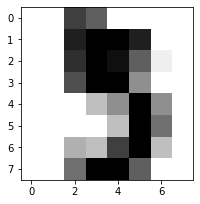

In [35]:
import requests
import json

Index = 5
# use the first row from the test set again
test_samples = json.dumps({"data": X_test[Index:Index+1].tolist()})

# create the required header
headers = {'Content-Type':'application/json'}

# post the request to the service and display the result
resp = requests.post(aci_service.scoring_uri, test_samples, headers = headers)
print("Predict " + resp.text)
print("Label " + str(Index))

fig = plt.figure(1, figsize=(3,3))
ax1 = fig.add_axes((0,0,.8,.8))
plt.imshow(images[Index], cmap = plt.cm.gray_r, interpolation = 'nearest')
plt.show()